# Importing Libs

In [7]:
from sklearn.datasets import fetch_olivetti_faces
from numpy.random import RandomState
import numpy as np
import cv2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten, Dropout, GlobalAveragePooling2D, Lambda
import tensorflow as tf
import tensorflow.keras.backend as k
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
from datetime import datetime

# Defining the Constants

In [8]:
model_save_name = 'custom_loss_function_in_siamese_network'

# Importing the Dataset

In [9]:
rng = RandomState(0)
# images_dataset, labels_dataset = fetch_olivetti_faces(return_X_y=True, shuffle=True, random_state=rng)
data = fetch_olivetti_faces(return_X_y=False, shuffle=True, random_state=rng)
images_dataset = data['images']
labels_dataset = data['target']
# n_samples, n_features = images_dataset.shape

# Functions

## Function to Display Images

In [10]:
def display_images(image1, image2):
  f, axarr = plt.subplots(1,2)
  # plt.figure()
  axarr[0].imshow(image1)
  axarr[1].imshow(image2)
  # plt.colorbar()
  plt.grid(False)
  plt.show()

# def display_images(image):
#   plt.figure()
#   plt.imshow(image)
#   plt.colorbar()
#   plt.grid(False)
#   plt.show()


## Function to Save the Model

In [11]:
def save_model(model_save_name):
  current_time = str(datetime.now())[:16].replace(':', '_')
  model.save(f'{model_save_name}_{current_time}.h5')

## Function to Calculate Euclidian Distance

In [12]:
def euclidean_distance(vectors):
    (featA, featB) = vectors
    sum_squared = k.sum(k.square(featA - featB), axis=1, keepdims=True)
    return k.sqrt(k.maximum(sum_squared, k.epsilon()))

## Function for Training Pairs Generation

In [31]:
def generate_train_image_pairs(images_dataset, labels_dataset):
    unique_labels = np.unique(labels_dataset)
    label_wise_indices = dict()
    for label in unique_labels:
        label_wise_indices.setdefault(label,
                                      [index for index, curr_label in enumerate(labels_dataset) if
                                       label == curr_label])
    
    pair_images = []
    pair_labels = []
    for index, image in enumerate(images_dataset):
        pos_indices = label_wise_indices.get(labels_dataset[index])
        pos_image = images_dataset[np.random.choice(pos_indices)]
        
        image = cv2.resize(image, dsize=(64, 64))
        
        pair_images.append((image, pos_image))
        pair_labels.append(1)

        neg_indices = np.where(labels_dataset != labels_dataset[index])
        neg_image = images_dataset[np.random.choice(neg_indices[0])]
        pair_images.append((image, neg_image))
        pair_labels.append(0)
    pair_labels = np.array(pair_labels)
    pair_labels = pair_labels.astype('float32')  
    return np.array(pair_images), np.array(pair_labels)

## Function for Testing Pairs Generation

In [32]:
def generate_test_image_pairs(images_dataset, labels_dataset, image):
    unique_labels = np.unique(labels_dataset)
    label_wise_indices = dict()
    for label in unique_labels:
        label_wise_indices.setdefault(label,
                                      [index for index, curr_label in enumerate(labels_dataset) if
                                        label == curr_label])
  
    pair_images = []
    pair_labels = []
    for label, indices_for_label in label_wise_indices.items():
        test_image = images_dataset[np.random.choice(indices_for_label)]
        pair_images.append((image, test_image))
        pair_labels.append(label)
    pair_labels = np.array(pair_labels)
    pair_labels = pair_labels.astype('float32')  
    return np.array(pair_images), np.array(pair_labels)

## Custom Loss Function

In [15]:
def contrastive_loss_with_margin(margin = 1):
  def contrastive_loss(y_true, y_pred):
    square_pred = k.square(y_pred)
    margin_square = k.square(k.maximum(margin - y_pred, 0))
    return k.mean(y_true * square_pred + (1 - y_true) * margin_square)
  return contrastive_loss

## Function to Define the Model

In [16]:
def create_model():
    inputs = Input((64, 64, 1))
    x = Conv2D(96, (11, 11), padding="same", activation="relu")(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)

    x = Conv2D(256, (5, 5), padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)

    x = Conv2D(384, (3, 3), padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)

    pooledOutput = GlobalAveragePooling2D()(x)
    pooledOutput = Dense(1024)(pooledOutput)
    outputs = Dense(128)(pooledOutput)

    model = Model(inputs, outputs)
    return model

# Generating Training Image Pairs

In [33]:
images_pair, labels_pair = generate_train_image_pairs(images_dataset, labels_dataset)

# Display Some Image Pairs

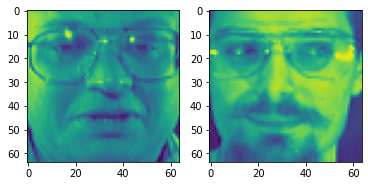

0.0


In [34]:
image_pair_num = 3
display_images(images_pair[image_pair_num][0], images_pair[image_pair_num][1])
print(labels_pair[image_pair_num])

# Feature Extraction

In [35]:
feature_extractor = create_model()
imgA = Input(shape=(64, 64, 1))
imgB = Input(shape=(64, 64, 1))
featA = feature_extractor(imgA)
featB = feature_extractor(imgB)

# Generating the Model

In [36]:
distance = Lambda(euclidean_distance)([featA, featB])
outputs = Dense(1, activation="sigmoid")(distance)
model = Model(inputs=[imgA, imgB], outputs=outputs)

# Compiling the Model

In [45]:
model.compile(loss = contrastive_loss_with_margin(margin = 0.5), optimizer="adam", metrics=["accuracy"])

# Plotting the Model

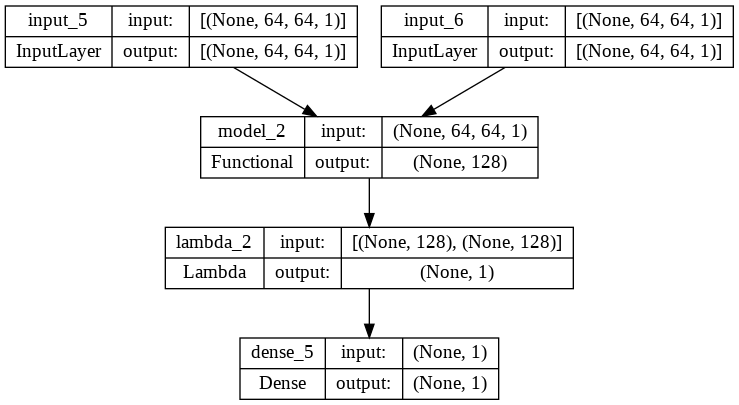

In [38]:
plot_model(model, show_shapes=True, show_layer_names=True, to_file= f'{model_save_name}.png')

# Plotting the Model (Simpler View)

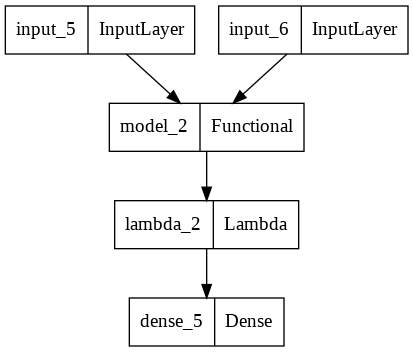

In [39]:
plot_model(model)

# Training the Model

In [46]:
history = model.fit([images_pair[:, 0], images_pair[:, 1]], labels_pair[:],validation_split=0.1,batch_size=64,epochs=100)

Epoch 1/100

12/12 [==============================] - 2s 112ms/step - loss: 0.0639 - accuracy: 0.3583 - val_loss: 0.0588 - val_accuracy: 0.5000

Epoch 2/100

12/12 [==============================] - 1s 93ms/step - loss: 0.0570 - accuracy: 0.4931 - val_loss: 0.0567 - val_accuracy: 0.5000

Epoch 3/100

12/12 [==============================] - 1s 93ms/step - loss: 0.0556 - accuracy: 0.4292 - val_loss: 0.0557 - val_accuracy: 0.5000

Epoch 4/100

12/12 [==============================] - 1s 95ms/step - loss: 0.0541 - accuracy: 0.4681 - val_loss: 0.0550 - val_accuracy: 0.5000

Epoch 5/100

12/12 [==============================] - 1s 94ms/step - loss: 0.0538 - accuracy: 0.4389 - val_loss: 0.0566 - val_accuracy: 0.4375

Epoch 6/100

12/12 [==============================] - 1s 94ms/step - loss: 0.0521 - accuracy: 0.4417 - val_loss: 0.0540 - val_accuracy: 0.5000

Epoch 7/100

12/12 [==============================] - 1s 94ms/step - loss: 0.0512 - accuracy: 0.4319 - val_loss: 0.0538 - val_accuracy:

# Saving the Model

In [50]:
save_model(model_save_name)

# Prediction

1/1 [==============================] - 0s 110ms/step


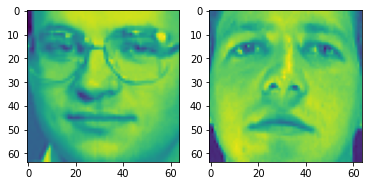

0.3307843 







1/1 [==============================] - 0s 16ms/step


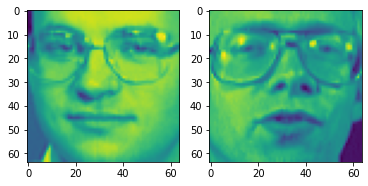

0.29806387 







1/1 [==============================] - 0s 16ms/step


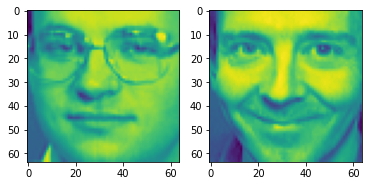

0.2504508 







1/1 [==============================] - 0s 23ms/step


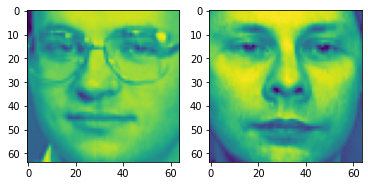

0.21150108 







1/1 [==============================] - 0s 20ms/step


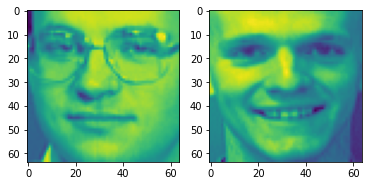

0.25137684 







1/1 [==============================] - 0s 17ms/step


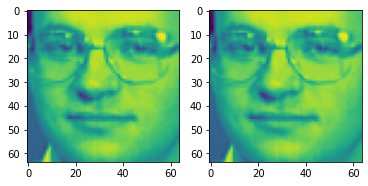

0.13265368 







1/1 [==============================] - 0s 16ms/step


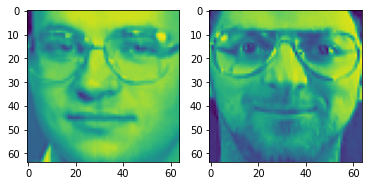

0.21007249 







1/1 [==============================] - 0s 17ms/step


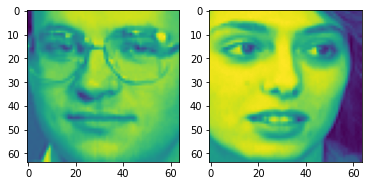

0.4261397 







1/1 [==============================] - 0s 26ms/step


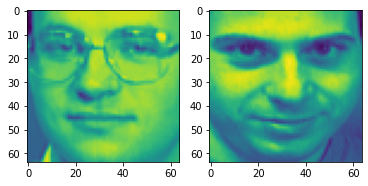

0.20385106 







1/1 [==============================] - 0s 17ms/step


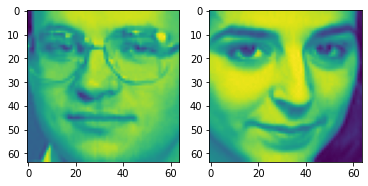

0.33290175 







1/1 [==============================] - 0s 16ms/step


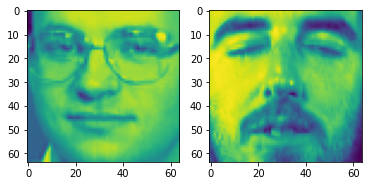

0.26681757 







1/1 [==============================] - 0s 17ms/step


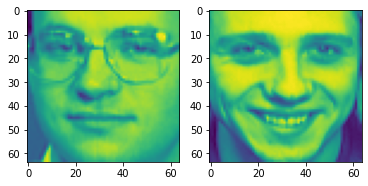

0.17936662 







1/1 [==============================] - 0s 21ms/step


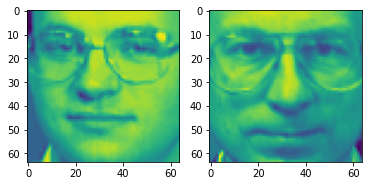

0.3202617 







1/1 [==============================] - 0s 17ms/step


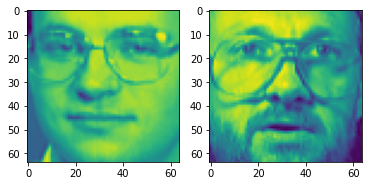

0.39259908 







1/1 [==============================] - 0s 20ms/step


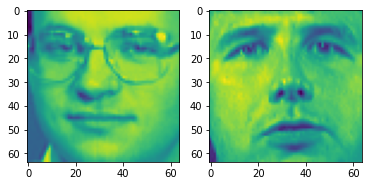

0.23859333 







1/1 [==============================] - 0s 17ms/step


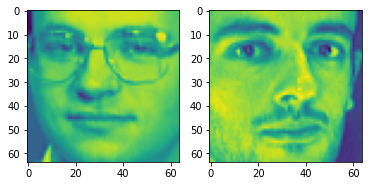

0.275882 







1/1 [==============================] - 0s 16ms/step


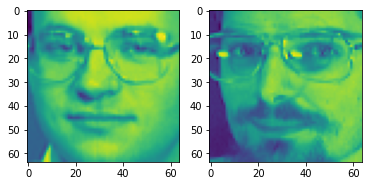

0.34231916 







1/1 [==============================] - 0s 17ms/step


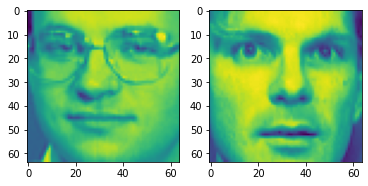

0.17487173 







1/1 [==============================] - 0s 23ms/step


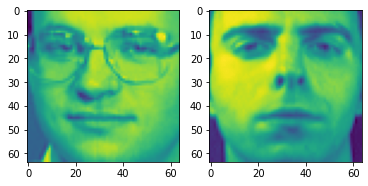

0.23863725 







1/1 [==============================] - 0s 24ms/step


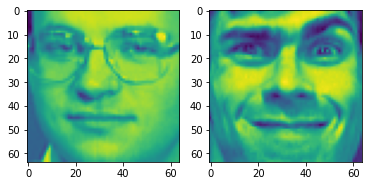

0.21477003 







1/1 [==============================] - 0s 17ms/step


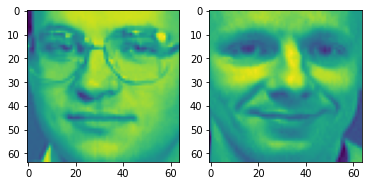

0.33599484 







1/1 [==============================] - 0s 18ms/step


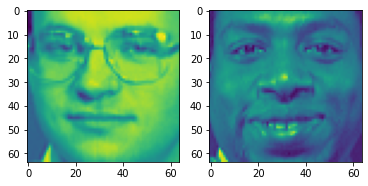

0.5368644 







1/1 [==============================] - 0s 16ms/step


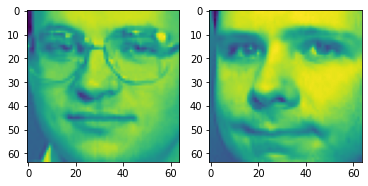

0.18921551 







1/1 [==============================] - 0s 16ms/step


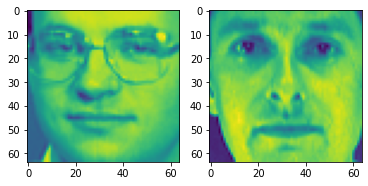

0.30988032 







1/1 [==============================] - 0s 17ms/step


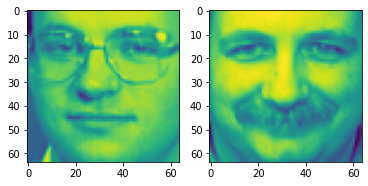

0.22182027 







1/1 [==============================] - 0s 16ms/step


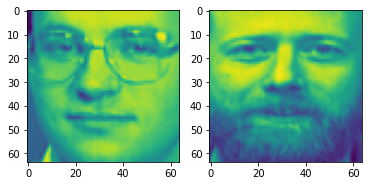

0.50994205 







1/1 [==============================] - 0s 20ms/step


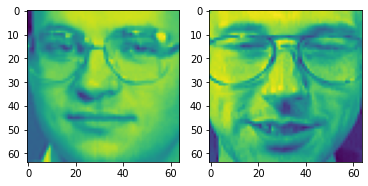

0.37656617 







1/1 [==============================] - 0s 20ms/step


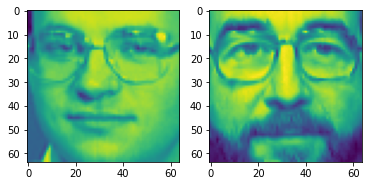

0.46881133 







1/1 [==============================] - 0s 19ms/step


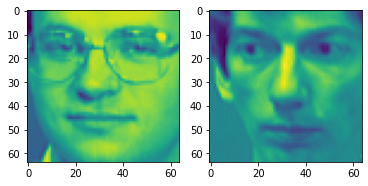

0.38960993 







1/1 [==============================] - 0s 17ms/step


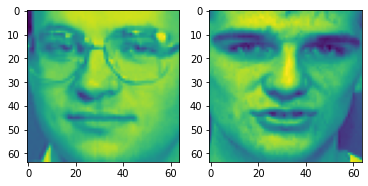

0.2481326 







1/1 [==============================] - 0s 17ms/step


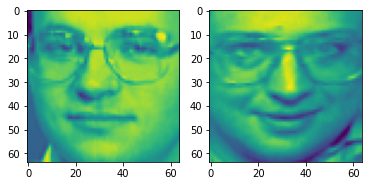

0.3941515 







1/1 [==============================] - 0s 18ms/step


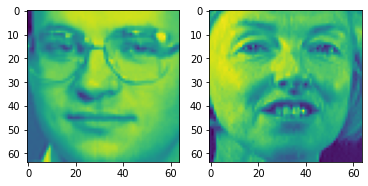

0.44441262 







1/1 [==============================] - 0s 25ms/step


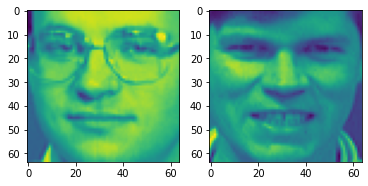

0.38603 







1/1 [==============================] - 0s 22ms/step


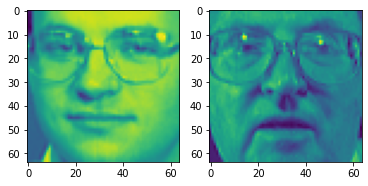

0.4570768 







1/1 [==============================] - 0s 20ms/step


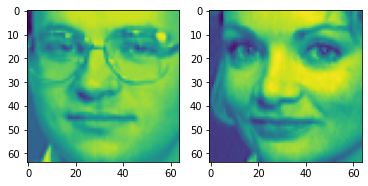

0.2402605 







1/1 [==============================] - 0s 23ms/step


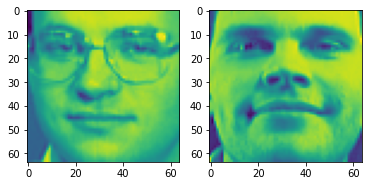

0.2754262 







1/1 [==============================] - 0s 22ms/step


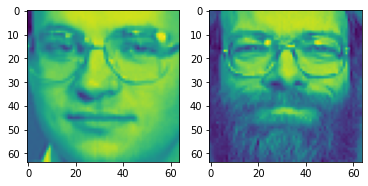

0.70208454 







1/1 [==============================] - 0s 20ms/step


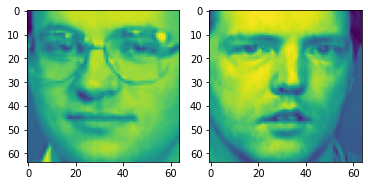

0.29970944 







1/1 [==============================] - 0s 21ms/step


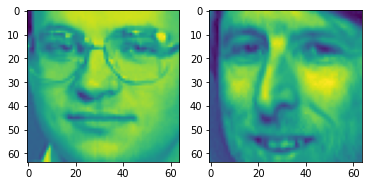

0.5421168 







1/1 [==============================] - 0s 26ms/step


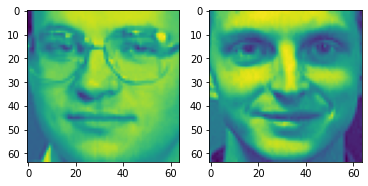

0.16644032 








In [47]:
image = images_dataset[92] # a random image as test image
test_image_pairs, test_label_pairs = generate_test_image_pairs(images_dataset, labels_dataset, image) # produce an array of test image pairs and test label pairs

# for each pair in the test image pair, predict the similarity between the images
for index, pair in enumerate(test_image_pairs):
    pair_image1 = np.expand_dims(pair[0], axis=-1)
    pair_image1 = np.expand_dims(pair_image1, axis=0)
    pair_image2 = np.expand_dims(pair[1], axis=-1)
    pair_image2 = np.expand_dims(pair_image2, axis=0)
    prediction = model.predict([pair_image1, pair_image2])[0][0]
    display_images(pair[0], pair[1])
    print(prediction,'\n'*3)

Credits :- Girija Shankar Behera

https://medium.com/wicds/face-recognition-using-siamese-networks-84d6f2e54ea4